### **Synthetic Time-Series Data Generation**

**Numpy e Pandas librerie**

In [2]:
import numpy as np
import pandas as pd

# Parameters
np.random.seed(42)
n_points = 1000
time_index = pd.date_range(start='2023-01-01', periods=n_points, freq='h')

# Generate normal data (e.g., sinusoidal pattern with noise)
normal_data = 10 + 2 * np.sin(np.linspace(0, 20 * np.pi, n_points)) + np.random.normal(0, 0.5, n_points)

# Create a DataFrame
normal_series = pd.DataFrame(data=normal_data, index=time_index, columns=['Value'])


**Introduce Anomalies**

Some common types of anomalies:
1. Point Anomalies: Sudden spikes or drops in the data.
2. Contextual Anomalies: Anomalies that are only considered unusual in a specific context (e.g., a temperature reading that is high for winter but normal for summer).
3. Collective Anomalies: A series of data points that collectively deviate from the expected pattern.

In [3]:
# Introduce point anomalies
anomalies = normal_series.copy()
anomalies.iloc[200] += 10  # Spike
anomalies.iloc[400] -= 5   # Drop
anomalies.iloc[600:610] += 15  # Collective anomaly

# Combine normal and anomalous data
combined_series = pd.concat([normal_series, anomalies], axis=1)
combined_series.columns = ['Normal', 'Anomalous']


**Visualize the Data**

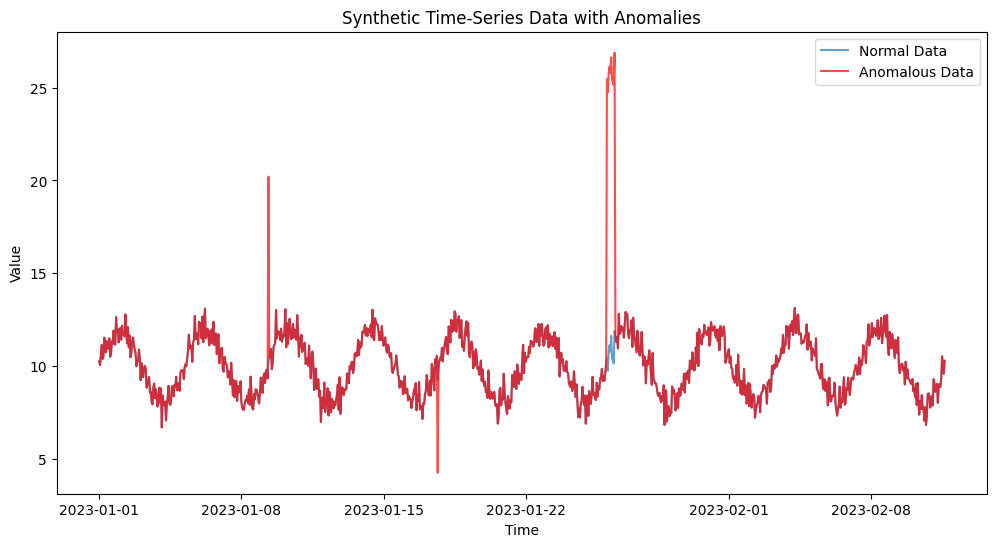

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(combined_series['Normal'], label='Normal Data', alpha=0.7)
plt.plot(combined_series['Anomalous'], label='Anomalous Data', color='red', alpha=0.7)
plt.title('Synthetic Time-Series Data with Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


**Prepare Data for DBSCAN and Isolation Forest**

In [6]:
from sklearn.preprocessing import StandardScaler

# Use the 'Anomalous' column for anomaly detection
data = combined_series['Anomalous'].values.reshape(-1, 1)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


**Implement DBSCAN**

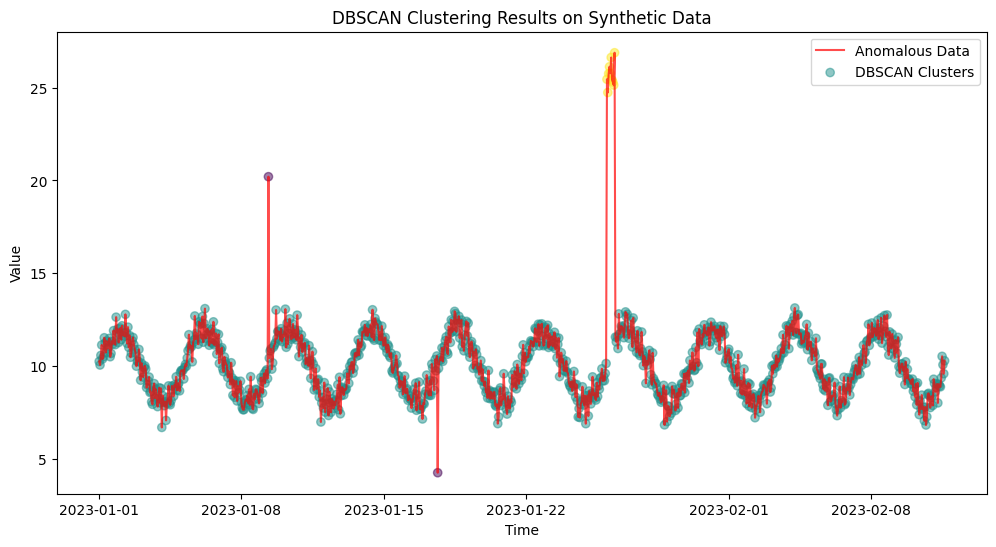

In [7]:
from sklearn.cluster import DBSCAN

# DBSCAN parameters
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)

# Add DBSCAN labels to the DataFrame
combined_series['DBSCAN'] = dbscan_labels

# Plot DBSCAN results
plt.figure(figsize=(12, 6))
plt.plot(combined_series['Anomalous'], label='Anomalous Data', color='red', alpha=0.7)
plt.scatter(combined_series.index, combined_series['Anomalous'], c=dbscan_labels, cmap='viridis', label='DBSCAN Clusters', alpha=0.5)
plt.title('DBSCAN Clustering Results on Synthetic Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


**Implement Isolation Forest**

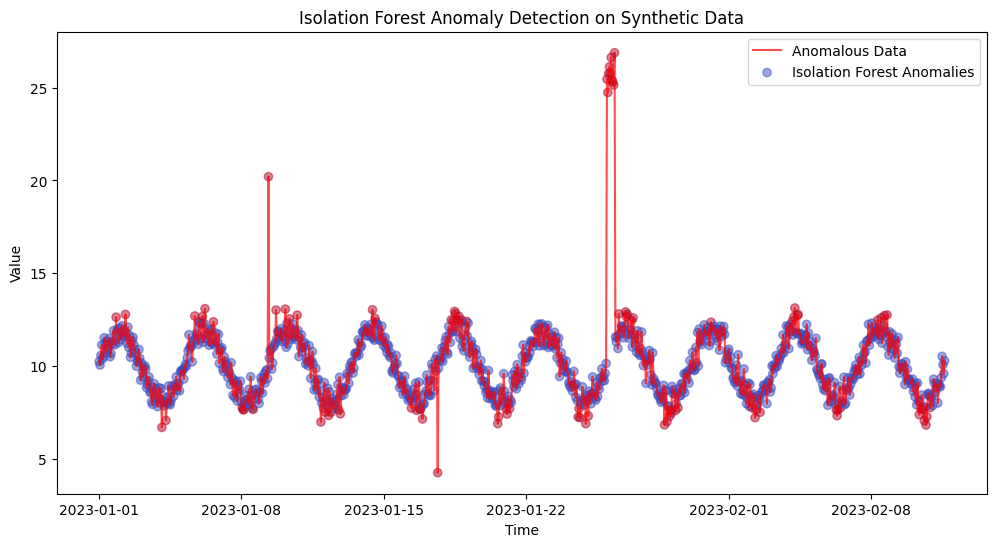

In [8]:
from sklearn.ensemble import IsolationForest

# Isolation Forest parameters
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(data_scaled)

# Predict anomalies
combined_series['Isolation Forest'] = iso_forest.predict(data_scaled)

# Convert predictions to a more interpretable format (1 for normal, -1 for anomaly)
combined_series['Isolation Forest'] = combined_series['Isolation Forest'].map({1: 0, -1: 1})

# Plot Isolation Forest results
plt.figure(figsize=(12, 6))
plt.plot(combined_series['Anomalous'], label='Anomalous Data', color='red', alpha=0.7)
plt.scatter(combined_series.index, combined_series['Anomalous'], c=combined_series['Isolation Forest'], cmap='coolwarm', label='Isolation Forest Anomalies', alpha=0.5)
plt.title('Isolation Forest Anomaly Detection on Synthetic Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


The Silhouette Score ranges from -1 to 1, where a score closer to 1 indicates better clustering quality. A score of 0 suggests overlapping clusters, and a negative score indicates that a sample might have been assigned to the wrong cluster.

In [9]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for DBSCAN
dbscan_silhouette_score = silhouette_score(data_scaled, dbscan_labels)
print(f"DBSCAN Silhouette Score: {dbscan_silhouette_score:.3f}")

# Calculate Silhouette Score for Isolation Forest
# Since Isolation Forest is not a clustering algorithm, we'll create pseudo-clusters based on anomaly scores
iso_forest_labels = combined_series['Isolation Forest'].replace({0: 1, 1: -1}).values
iso_forest_silhouette_score = silhouette_score(data_scaled, iso_forest_labels)
print(f"Isolation Forest Silhouette Score: {iso_forest_silhouette_score:.3f}")


DBSCAN Silhouette Score: 0.784
Isolation Forest Silhouette Score: 0.527


## Generate Synthetic Time-Series Data

**Tslearn** library specifically designed for time-series data, offering tools for generating synthetic time-series datasets.

In [15]:
!pip install tslearn --index-url https://pypi.python.org/simple/


Looking in indexes: https://pypi.python.org/simple/
ERROR: Could not find a version that satisfies the requirement tslearn (from versions: none)
ERROR: No matching distribution found for tslearn


In [18]:
#!pip install tslearn 


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.datasets import TimeSeriesGenerator

# Generate synthetic time-series data
n_samples = 100
time_length = 50

# Create a sine wave with added noise
X = np.array([np.sin(np.linspace(0, 2 * np.pi, time_length)) + np.random.normal(0, 0.1, time_length) for _ in range(n_samples)])

# Visualize the synthetic time-series data
plt.figure(figsize=(10, 5))
for series in X:
    plt.plot(series, color='blue', alpha=0.5)
plt.title("Synthetic Time-Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


ModuleNotFoundError: No module named 'tslearn'

**DBSCAN algorithm to cluster the synthetic time-series data:**

In [ ]:
from sklearn.cluster import DBSCAN
from tslearn.preprocessing import TimeSeriesScalerMinMax

# Scale the data
scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled.reshape(n_samples, -1))  # Reshape for DBSCAN

# Visualize DBSCAN results
plt.figure(figsize=(10, 5))
for label in np.unique(dbscan_labels):
    plt.scatter(np.arange(n_samples)[dbscan_labels == label], 
                X_scaled[dbscan_labels == label].reshape(-1, time_length)[:, 0], 
                label=f'Cluster {label}')
plt.title("DBSCAN Clustering Results")
plt.xlabel("Sample Index")
plt.ylabel("Scaled Value")
plt.legend()
plt.show()


**Isolation Forest algorithm to detect anomalies in the synthetic time-series data:**

In [ ]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_scaled.reshape(n_samples, -1))

# Predict anomalies
anomaly_labels = iso_forest.predict(X_scaled.reshape(n_samples, -1))

# Convert predictions to a more interpretable format (1 for normal, -1 for anomaly)
anomaly_labels = np.where(anomaly_labels == 1, 0, 1)

# Visualize Isolation Forest results
plt.figure(figsize=(10, 5))
for label in np.unique(anomaly_labels):
    plt.scatter(np.arange(n_samples)[anomaly_labels == label], 
                X_scaled[anomaly_labels == label].reshape(-1, time_length)[:, 0], 
                label=f'Anomaly {label}')
plt.title("Isolation Forest Anomaly Detection Results")
plt.xlabel("Sample Index")
plt.ylabel("Scaled Value")
plt.legend()
plt.show()
